## Multi-label classification

Unofficial Lecture Notes
- http://forums.fast.ai/t/deeplearning-lecnotes2/7515
- http://forums.fast.ai/t/deeplearning-lecnotes3/7866
- https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-2-eeae2edd2be4
- https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-3-74b0ef79e56

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

# !kg download -c planet-understanding-the-amazon-from-space
# !sudo apt-get install -y p7zip-full
# !7z x train-jpg.tar.7z
# !tar xvf train-jpg.tar
# !7z x test-jpg.tar.7z
# !tar xvf test-jpg.tar
# !unzip train_v2.csv.zip

In [4]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

In [4]:
ls {PATH}

__MACOSX/  sample_submission_v2.csv  test-jpg/  tmp/  train-jpg/  train_v2.csv


## Multi-label versus single-label classification

In [5]:
from fastai.plots import *

In [6]:
def get_1st(path): return glob(f'{path}/*.*')[0]

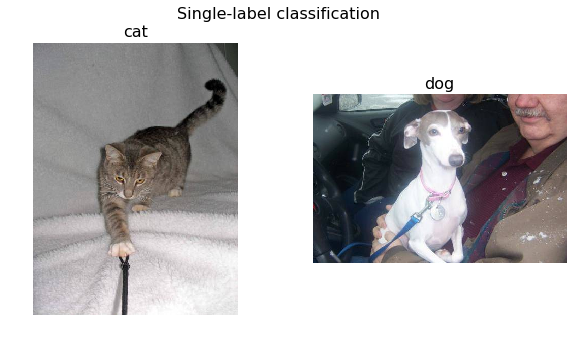

In [7]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

#Source:   
#def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
#    """Plots images given image files.
#    
#    Arguments:
#        im_paths (list): list of paths
#        figsize (tuple): figure size
#        rows (int): number of rows
#        titles (list): list of titles
#        maintitle (string): main title
#    """
#    f = plt.figure(figsize=figsize)
#    if maintitle is not None: plt.suptitle(maintitle, fontsize=16)
#    for i in range(len(imspaths)):
#        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
#        sp.axis('Off')
#        if titles is not None: sp.set_title(titles[i], fontsize=16)
#        img = plt.imread(imspaths[i])
#        plt.imshow(img)
#File:      ~/fastai/courses/dl1/fastai/plots.py

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

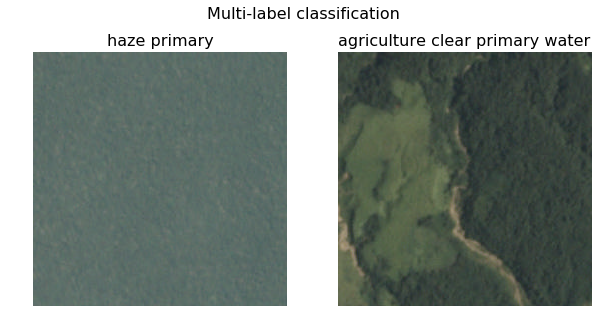

In [8]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [9]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [10]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [11]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [12]:
data = get_data(256)

In [13]:
dir(data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'aug_dl',
 'bs',
 'c',
 'classes',
 'fix_dl',
 'from_arrays',
 'from_csv',
 'from_dls',
 'from_paths',
 'get_dl',
 'get_ds',
 'is_multi',
 'is_reg',
 'num_workers',
 'path',
 'resize',
 'resized',
 'sz',
 'test_aug_dl',
 'test_dl',
 'test_ds',
 'trn_dl',
 'trn_ds',
 'trn_y',
 'val_dl',
 'val_ds',
 'val_y']

In [14]:
x,y = next(iter(data.val_dl)) # dl is a data loader which will give you a mini-batch, specifically transformed mini-batch.

In [15]:
y # (64, 17)   64=batch size, 17=classes


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [17]:
# You'll see y[0] has multiple labels.
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

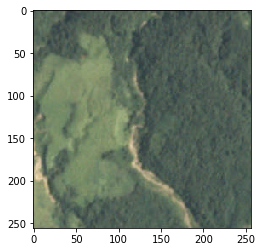

In [18]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [19]:
# We will not use sz=64 for cats and dogs competition because we started with pre-trained ImageNet network which starts off nearly perfect. 
# If we re-trained the whole set with 64 by 64 images, we would destroy the weights that are already very good. 
# Remember, most of ImageNet models are trained with 224 by 224 or 299 by 299 images.
# There is no images in ImageNet that looks like the one above. And only the first couple layers are useful to us. 
# So starting out with smaller images works well in this case.
sz=64

In [20]:
data = get_data(sz) # fastai.dataset.ImageClassifierData

In [23]:
# If the initial image is 1000 by 1000, reading that JPEG and resizing it to 64 by 64 take more time than training the convolutional net. 
# data.resize tells it that we will not use images bigger than sz*1.3 so go through once and create new JPEGs of this size. 
# Since images are rectangular, so new JPEGs whose smallest edge is sz*1.3 (center-cropped). It will save you a lot of time.
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [24]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.217454   0.315462   0.782472  



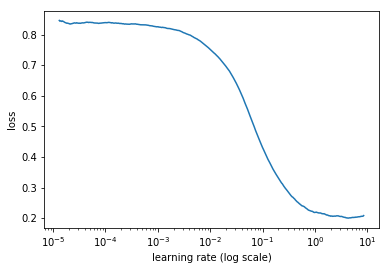

In [25]:
lrf=learn.lr_find()
learn.sched.plot()

In [26]:
lr = 0.2

In [27]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) # 1 + 2 + 4 = 7 epochs

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.145097   0.135081   0.881037  
    1      0.141713   0.129679   0.887471                    
    2      0.137643   0.127408   0.888684                    
    3      0.135288   0.126801   0.88859                     
    4      0.135125   0.124427   0.891684                    
    5      0.134855   0.123275   0.892206                    
    6      0.132728   0.123121   0.893227                    



[0.12312146, 0.8932265568757054]

In [28]:
lrs = np.array([lr/9,lr/3,lr])

In [29]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.122243   0.109256   0.908537  
    1      0.116865   0.106125   0.90988                     
    2      0.110034   0.101096   0.914762                    
    3      0.111698   0.104663   0.910937                    
    4      0.103582   0.099832   0.914466                    
    5      0.099675   0.097971   0.916849                     
    6      0.097942   0.097487   0.916606                     



[0.097486615, 0.9166064822394782]

In [30]:
learn.save(f'{sz}')

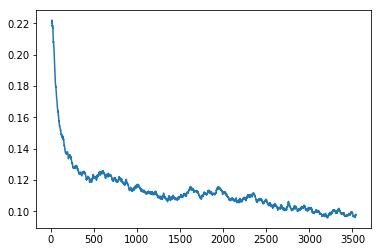

In [31]:
learn.sched.plot_loss()

In [32]:
sz=128

In [33]:
# http://forums.fast.ai/t/planet-classification-challenge/7824/95
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(sz)) # bigger image (64 -> 128)
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.096458   0.095677   0.919576  
    1      0.094966   0.094312   0.919903                     
    2      0.093892   0.093319   0.921823                     
    3      0.097867   0.093371   0.920912                     
    4      0.095397   0.092589   0.922301                     
    5      0.093373   0.092154   0.92191                      
    6      0.095872   0.091821   0.922789                     



[0.09182093, 0.9227887067504509]

In [34]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.094148   0.087669   0.926696  
    1      0.094097   0.087575   0.926922                     
    2      0.088405   0.086465   0.927532                     
    3      0.093286   0.087382   0.926809                     
    4      0.088201   0.085829   0.929291                     
    5      0.085019   0.085796   0.928496                     
    6      0.08224    0.084445   0.929375                     



In [35]:
sz=256

In [36]:
learn.set_data(get_data(sz)) # further bigger image (128 -> 256)
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.08998    0.090219   0.92432   
    1      0.090578   0.0889     0.926508                     
    2      0.08621    0.088231   0.926323                     
    3      0.089639   0.088083   0.927685                     
    4      0.089641   0.087334   0.92784                      
    5      0.084739   0.087219   0.927691                     
    6      0.087776   0.087075   0.928014                     



[0.08707532, 0.9280139718108606]

In [37]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.08491    0.083946   0.930358  
    1      0.086383   0.084132   0.929241                     
    2      0.082851   0.082281   0.931775                     
    3      0.086364   0.083675   0.930999                     
    4      0.08306    0.083131   0.930616                     
    5      0.078672   0.081176   0.932652                     
    6      0.078784   0.08132    0.932283                     



In [38]:
multi_preds, y = learn.TTA() # ((5, 8095, 17), (8095, 17))
preds = np.mean(multi_preds, 0) # (8095, 17)

In [41]:
f2(preds,y)

#Source:   
#def f2(preds, targs, start=0.17, end=0.24, step=0.01):
#    with warnings.catch_warnings():
#        warnings.simplefilter("ignore")
#        return max([fbeta_score(targs, (preds>th), 2, average='samples')
#                    for th in np.arange(start,end,step)])
#File:      ~/fastai/courses/dl1/planet.py

# F-beta score
#https://stats.stackexchange.com/questions/221997/why-f-beta-score-define-beta-like-that

0.9307253346130788

### End